In [5]:
import wandb
wandb.login()
import os
os.environ['WANDB_PROJECT'] = 'generalist_model'
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import csrgraph as cg
import numpy as np
import random
import string
from itertools import combinations
import pickle
import gc
import os
import json
from transformers import GPT2LMHeadModel, GPT2Tokenizer

#os.environ['WANDB_MODE'] = 'disabled'

In [6]:
# set current directory
os.chdir("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS")

**DATA GENERATION**

In [7]:
import networkx as nx
import random
import string
import itertools
import numpy as np

def get_graph(nodes):
    """Creates a standard 3x3 grid graph with named nodes."""
    G = nx.DiGraph()
    size = int(np.sqrt(len(nodes)))
    if size * size != len(nodes):
        raise ValueError("Number of nodes must be a perfect square.")

    for r in range(size):
        for c in range(size):
            idx = r * size + c
            # East
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx + 1], direction='EAST')
            # West
            if c > 0: G.add_edge(nodes[idx], nodes[idx - 1], direction='WEST')
            # South
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx + size], direction='SOUTH')
            # North
            if r > 0: G.add_edge(nodes[idx], nodes[idx - size], direction='NORTH')
    return G

def generate_name() -> str:
    """Generates a random 2-character lowercase string for a node name."""
    return ''.join(random.choices(string.ascii_lowercase, k=2))

def generate_all_shortest_paths(G, min_length):
    """
    Generates all unique shortest paths between all pairs of nodes,
    filtered by a minimum length.
    """
    nodes = list(G.nodes())
    all_paths = []
    for start_node, end_node in itertools.permutations(nodes, 2):
        paths_generator = nx.all_shortest_paths(G, source=start_node, target=end_node)
        for path in paths_generator:
            # The length of a path is the number of nodes. A 3-step path has 4 nodes.
            if len(path) >= min_length + 1:
                all_paths.append({'start': start_node, 'end': end_node, 'path': path})
    # Use a set of tuples to find and remove duplicate paths
    unique_path_tuples = {tuple(p['path']) for p in all_paths}
    # Rebuild the list of dicts from the unique paths
    final_unique_paths = []
    seen_paths = set()
    for p in all_paths:
        path_tuple = tuple(p['path'])
        if path_tuple not in seen_paths:
            final_unique_paths.append(p)
            seen_paths.add(path_tuple)
    return final_unique_paths

def generate_foraging_path(G, walk_length):
    """Generates a single, long random walk with node revisits allowed."""
    nodes = list(G.nodes())
    start_node = random.choice(nodes)
    path = [start_node]
    current_node = start_node
    
    while len(path) < walk_length:
        neighbors = list(G.successors(current_node))
        if not neighbors: break 
        next_node = random.choice(neighbors)
        path.append(next_node)
        current_node = next_node
        
    return {'start': path[0], 'end': path[-1], 'path': path}

def format_path_string(path_dict, G, mode):
    """Creates the final string representation for a path."""
    path = path_dict['path']
    if not path: return ""

    if mode == "Shortest":
        header = f"MODE Shortest START {path_dict['start']} END {path_dict['end']} PATH "
    elif mode == "Foraging":
        header = f"MODE Foraging START {path_dict['start']} PATH "
    else:
        raise ValueError("Invalid mode specified")

    path_body = ""
    for i in range(len(path) - 1):
        node1, node2 = path[i], path[i+1]
        try:
            direction = G.edges[(node1, node2)]['direction']
            path_body += f"{node1} {direction} "
        except KeyError:
            return None # Skip malformed path
    
    path_body += path[-1]
    return header + path_body

def get_walks_as_strings(n_graphs=100, n_walks=None, walk_length=50, min_shortest_path_length=3):
    """
    Orchestrates the generation of a full, balanced dataset of ShortestPath and Foraging examples.
    
    NOTE: The `n_walks` parameter from your original script is no longer used, as this function
    now generates an exhaustive set of shortest paths and a balanced number of foraging paths
    to create a more scientifically rigorous dataset. The `walk_length` parameter now only
    applies to foraging paths.
    """
    master_dataset = []
    all_graphs = []
    print(f"Starting 'gold standard' dataset generation for {n_graphs} unique environments...")

    for i in range(n_graphs):
        nodes = [generate_name() for _ in range(9)] # 3x3 grid
        G = get_graph(nodes=nodes)
        
        # 1. Generate all valid shortest paths
        shortest_paths = generate_all_shortest_paths(G, min_length=min_shortest_path_length)
        
        # 2. Generate an equal number of foraging paths
        num_to_generate = len(shortest_paths)
        if num_to_generate == 0: continue
            
        foraging_paths = [generate_foraging_path(G, walk_length=walk_length) for _ in range(num_to_generate)]
        
        # 3. Format and combine strings for this environment
        environment_strings = []
        for p in shortest_paths:
            s = format_path_string(p, G, "Shortest")
            if s: environment_strings.append(s)
            
        for p in foraging_paths:
            s = format_path_string(p, G, "Foraging")
            if s: environment_strings.append(s)
            
        random.shuffle(environment_strings)
        master_dataset.extend(environment_strings)
        all_graphs.append(G)
        
        if (i + 1) % (n_graphs // 10 or 1) == 0:
            print(f"  ...processed {i+1}/{n_graphs} environments. Total paths so far: {len(master_dataset)}")

    random.shuffle(master_dataset)
    print("\nDataset generation complete.")
    return master_dataset, all_graphs

In [29]:
import os
import shutil
import random


if __name__ == "__main__":
    # --- Configuration ---
    # WARNING: The 'exhaustive' shortest path method is computationally intensive.
    # A value like n_graphs=500,000 is not feasible. 
    # Start with a smaller number like 1,000-5,000 to test your pipeline.
    N_GRAPHS_TRAIN = 5000 
    N_GRAPHS_TEST = 100
    FORAGING_PATH_LENGTH = 50
    MIN_SHORTEST_PATH_STEPS = 2

    # Set a seed for reproducibility
    random.seed(42)

    # --- Setup Output Directory ---
    output_dir = "generalist_data"
    if os.path.exists(output_dir):
        print(f"Removing existing directory: {output_dir}")
        shutil.rmtree(output_dir)
    print(f"Creating new directory: {output_dir}")
    os.makedirs(output_dir)

    # --- Generate Training Data ---
    print("\n--- Generating Training Data ---")
    train_walks, train_gs = get_walks_as_strings(
        n_graphs=N_GRAPHS_TRAIN,
        walk_length=FORAGING_PATH_LENGTH,
        min_shortest_path_length=MIN_SHORTEST_PATH_STEPS
        # Note: n_walks is not needed here
    )

    train_file_path = os.path.join(output_dir, "train.txt")
    print(f"Writing {len(train_walks)} training examples to {train_file_path}...")
    with open(train_file_path, "w") as f:
        f.write('\n'.join(train_walks))

    # --- Generate Testing Data ---
    print("\n--- Generating Testing Data ---")
    test_walks, test_gs = get_walks_as_strings(
        n_graphs=N_GRAPHS_TEST,
        walk_length=FORAGING_PATH_LENGTH,
        min_shortest_path_length=MIN_SHORTEST_PATH_STEPS
    )
    
    test_file_path = os.path.join(output_dir, "test.txt")
    print(f"Writing {len(test_walks)} testing examples to {test_file_path}...")
    with open(test_file_path, "w") as f:
        f.write('\n'.join(test_walks))

    print("\nProcess finished successfully.")

Removing existing directory: generalist_data
Creating new directory: generalist_data

--- Generating Training Data ---
Starting 'gold standard' dataset generation for 5000 unique environments...
  ...processed 500/5000 environments. Total paths so far: 113152
  ...processed 1000/5000 environments. Total paths so far: 226776
  ...processed 1500/5000 environments. Total paths so far: 339240
  ...processed 2000/5000 environments. Total paths so far: 452864
  ...processed 2500/5000 environments. Total paths so far: 565772
  ...processed 3000/5000 environments. Total paths so far: 678984
  ...processed 3500/5000 environments. Total paths so far: 791756
  ...processed 4000/5000 environments. Total paths so far: 905920
  ...processed 4500/5000 environments. Total paths so far: 1019516
  ...processed 5000/5000 environments. Total paths so far: 1132944

Dataset generation complete.
Writing 1132944 training examples to generalist_data/train.txt...

--- Generating Testing Data ---
Starting 'gold 

**EDA**

Generating a temporary dataset from 50 unique 3x3 environments...
Temporary structured dataset generated.

--- Starting Deep EDA on 11276 generated paths ---

--- 1. Node Visit Frequency ---


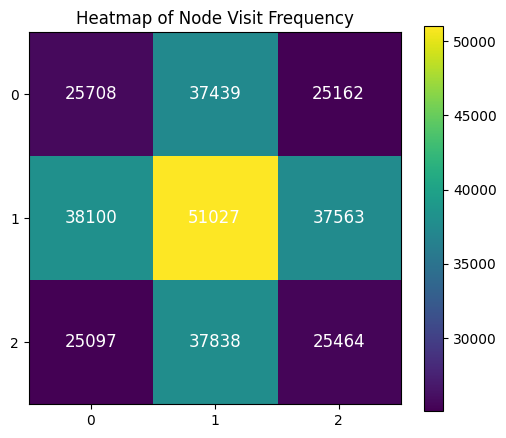


--- 2. Directional Bias ---
⚠️ Found and ignored 1419 invalid (non-cardinal) moves during analysis.


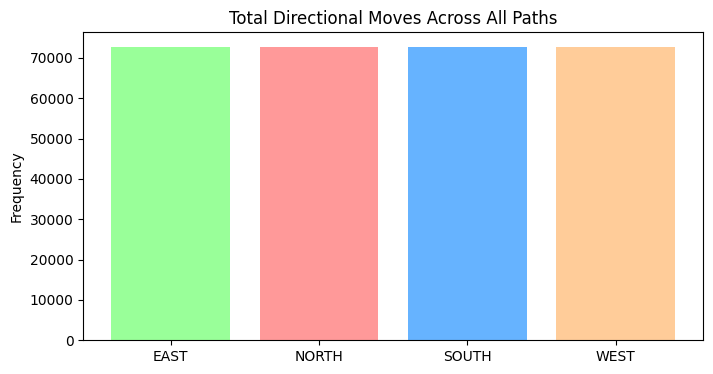

Counter({'EAST': 72721, 'SOUTH': 72716, 'NORTH': 72655, 'WEST': 72611})

--- 3. Start/End Node Positional Bias ---
Start Node Type Counts:
start_type
Corner    5601
Edge      4684
Center     991
Name: count, dtype: int64


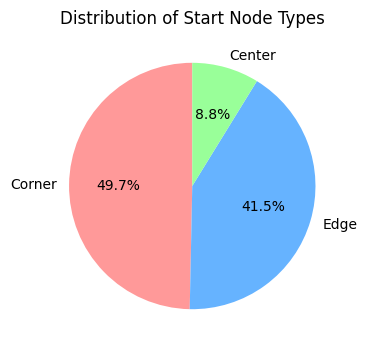


--- 4. Turn Bias (Shortest Paths only) ---


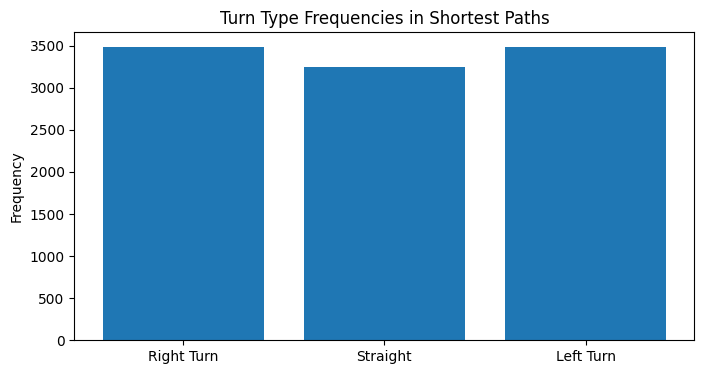

Counter({'Right Turn': 3485, 'Left Turn': 3485, 'Straight': 3252})


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import string
import itertools
from collections import Counter

## EDA with fake data

def generate_name() -> str:
    """Generates a random 2-character lowercase string for a node name."""
    return ''.join(random.choices(string.ascii_lowercase, k=2))

def format_path_string(path_dict, G, mode, node_to_coord_map):
    """Creates the final string representation for a path."""
    path_nodes = path_dict['path']
    if not path_nodes: return ""

    start_node_name = path_nodes[0]
    end_node_name = path_nodes[-1]
    
    if mode == "Shortest":
        header = f"MODE: Shortest, FROM: {start_node_name}, TO: {end_node_name}, PATH: "
    elif mode == "Foraging":
        header = f"MODE: Foraging, START: {start_node_name}, PATH: "
    else:
        raise ValueError("Invalid mode specified")

    path_body = ""
    for i in range(len(path_nodes) - 1):
        node1, node2 = path_nodes[i], path_nodes[i+1]
        try:
            direction = G.edges[(node1, node2)]['direction']
            path_body += f"{node1} {direction} "
        except KeyError: return None 
    
    path_body += path_nodes[-1]
    
    # Also return the path in coordinate form for analysis
    path_coords = [node_to_coord_map[node] for node in path_nodes]
    
    return header + path_body, path_coords

def generate_deep_analysis_dataset(n_graphs=100, grid_size=3, walk_length=50, min_shortest_path_length=3):
    """
    Generates a dataset and returns it in a structured format with coordinate ground truth.
    """
    structured_dataset = []
    num_nodes = grid_size * grid_size
    print(f"Generating a temporary dataset from {n_graphs} unique {grid_size}x{grid_size} environments...")

    for i in range(n_graphs):
        # Create environment and mapping from random name to canonical coordinate
        node_names = [generate_name() for _ in range(num_nodes)]
        coord_map = {name: (r, c) for r, row in enumerate(np.array(node_names).reshape(grid_size, grid_size)) for c, name in enumerate(row)}
        node_to_coord_map = {name: coord for name, coord in coord_map.items()}

        G = nx.grid_2d_graph(grid_size, grid_size)
        # Relabel nodes to use the random names but keep coordinate structure
        G = nx.relabel_nodes(G, {(r,c): node_names[r*grid_size+c] for r in range(grid_size) for c in range(grid_size)})
        # Add direction attributes
        for u, v in G.edges():
            u_coord, v_coord = node_to_coord_map[u], node_to_coord_map[v]
            if v_coord[1] > u_coord[1]: G.edges[u,v]['direction'] = 'EAST'
            elif v_coord[1] < u_coord[1]: G.edges[u,v]['direction'] = 'WEST'
            elif v_coord[0] > u_coord[0]: G.edges[u,v]['direction'] = 'SOUTH'
            else: G.edges[u,v]['direction'] = 'NORTH'
        G = nx.DiGraph(G) # Make it directed

        # Generate paths
        shortest_paths_dicts = generate_all_shortest_paths(G, min_shortest_path_length)
        num_to_generate = len(shortest_paths_dicts)
        if num_to_generate == 0: continue
            
        foraging_paths_dicts = [generate_foraging_path(G, walk_length) for _ in range(num_to_generate)]

        # Format and store with coordinate data
        for p in shortest_paths_dicts:
            formatted_string, path_coords = format_path_string(p, G, "Shortest", node_to_coord_map)
            if formatted_string:
                structured_dataset.append({'mode': 'Shortest', 'path_coords': path_coords})
        
        for p in foraging_paths_dicts:
            formatted_string, path_coords = format_path_string(p, G, "Foraging", node_to_coord_map)
            if formatted_string:
                structured_dataset.append({'mode': 'Foraging', 'path_coords': path_coords})

    random.shuffle(structured_dataset)
    print("Temporary structured dataset generated.")
    return structured_dataset

# (Other helper functions like generate_all_shortest_paths, generate_foraging_path can be copied from your previous script)
def generate_all_shortest_paths(G, min_length):
    nodes = list(G.nodes())
    all_paths = []
    for start_node, end_node in itertools.permutations(nodes, 2):
        paths_generator = nx.all_shortest_paths(G, source=start_node, target=end_node)
        for path in paths_generator:
            if len(path) >= min_length + 1:
                all_paths.append({'start': start_node, 'end': end_node, 'path': path})
    unique_path_tuples = {tuple(p['path']) for p in all_paths}
    final_unique_paths = []
    seen_paths = set()
    for p in all_paths:
        path_tuple = tuple(p['path'])
        if path_tuple not in seen_paths:
            final_unique_paths.append(p)
            seen_paths.add(path_tuple)
    return final_unique_paths

def generate_foraging_path(G, walk_length):
    nodes = list(G.nodes())
    start_node = random.choice(nodes)
    path = [start_node]
    current_node = start_node
    while len(path) < walk_length:
        neighbors = list(G.successors(current_node))
        if not neighbors: break 
        next_node = random.choice(neighbors)
        path.append(next_node)
        current_node = next_node
    return {'start': path[0], 'end': path[-1], 'path': path}


## main part

if __name__ == "__main__":
    # --- Config ---
    N_GRAPHS_EDA = 50
    GRID_SIZE_EDA = 3
    FORAGING_PATH_LENGTH = 50
    MIN_SHORTEST_PATH_STEPS = 2

    random.seed(42)

    # 1. Generate the structured dataset
    structured_data = generate_deep_analysis_dataset(
        n_graphs=N_GRAPHS_EDA,
        grid_size=GRID_SIZE_EDA,
        walk_length=FORAGING_PATH_LENGTH,
        min_shortest_path_length=MIN_SHORTEST_PATH_STEPS
    )
    df = pd.DataFrame(structured_data)

    print(f"\n--- Starting Deep EDA on {len(df)} generated paths ---")

    # --- Analysis 1: Node Visit Frequency ---
    print("\n--- 1. Node Visit Frequency ---")
    all_nodes_visited = [node for path in df['path_coords'] for node in path]
    node_counts = Counter(all_nodes_visited)
    
    heatmap_data = np.zeros((GRID_SIZE_EDA, GRID_SIZE_EDA))
    for (r, c), count in node_counts.items():
        heatmap_data[r, c] = count
        
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(heatmap_data, cmap="viridis")
    ax.set_xticks(np.arange(GRID_SIZE_EDA))
    ax.set_yticks(np.arange(GRID_SIZE_EDA))
    for r in range(GRID_SIZE_EDA):
        for c in range(GRID_SIZE_EDA):
            ax.text(c, r, f"{int(heatmap_data[r, c])}", ha="center", va="center", color="w", fontsize=12)
    ax.set_title("Heatmap of Node Visit Frequency")
    plt.colorbar(im)
    plt.show()

    # --- Analysis 2: Directional Bias ---
    print("\n--- 2. Directional Bias ---")
    direction_map = {(0, 1): 'EAST', (0, -1): 'WEST', (1, 0): 'SOUTH', (-1, 0): 'NORTH'}
    all_directions = []
    invalid_moves_found = 0

    for path in df['path_coords']:
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            dr, dc = v[0] - u[0], v[1] - u[1]
            
            # --- THE FIX IS HERE ---
            # Use direct dictionary access, which will raise a KeyError on an invalid move.
            # This is better than .get() because it fails loudly.
            direction = direction_map.get((dr, dc))
            if direction:
                all_directions.append(direction)
            else:
                # If the move is not a valid cardinal direction, log it but don't add None.
                invalid_moves_found += 1
                # print(f"Warning: Invalid move detected from {u} to {v}. Skipping.") # Uncomment for detailed debugging

    if invalid_moves_found > 0:
        print(f"⚠️ Found and ignored {invalid_moves_found} invalid (non-cardinal) moves during analysis.")

    direction_counts = Counter(all_directions)
    # Create a list of colors that maps to the specific keys found, in a consistent order
    keys_in_order = sorted(direction_counts.keys())
    colors_in_order = {'NORTH':'#ff9999', 'SOUTH':'#66b3ff', 'EAST':'#99ff99', 'WEST':'#ffcc99'}
    bar_colors = [colors_in_order.get(key, '#cccccc') for key in keys_in_order]

    plt.figure(figsize=(8, 4))
    # Plot using the sorted keys to ensure consistent bar order
    plt.bar(keys_in_order, [direction_counts[k] for k in keys_in_order], color=bar_colors)
    plt.title("Total Directional Moves Across All Paths")
    plt.ylabel("Frequency")
    plt.show()
    print(direction_counts)

    # --- Analysis 3: Start/End Node Positional Bias ---
    print("\n--- 3. Start/End Node Positional Bias ---")
    def get_node_type(coord, size):
        if coord in [(0,0), (0,size-1), (size-1,0), (size-1,size-1)]: return 'Corner'
        elif coord[0] in [0, size-1] or coord[1] in [0, size-1]: return 'Edge'
        else: return 'Center'

    df['start_coord'] = df['path_coords'].apply(lambda x: x[0])
    df['start_type'] = df['start_coord'].apply(lambda x: get_node_type(x, GRID_SIZE_EDA))
    
    start_type_counts = df['start_type'].value_counts()
    print("Start Node Type Counts:")
    print(start_type_counts)

    plt.figure(figsize=(6,4))
    start_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
    plt.title("Distribution of Start Node Types")
    plt.ylabel('') # Hides the 'None' label
    plt.show()

    # --- Analysis 4: Turn Bias (for Shortest Paths) ---
    print("\n--- 4. Turn Bias (Shortest Paths only) ---")
    shortest_df = df[df['mode'] == 'Shortest']
    turn_types = []
    for path in shortest_df['path_coords']:
        if len(path) < 3: continue
        for i in range(len(path) - 2):
            p1, p2, p3 = path[i], path[i+1], path[i+2]
            d1 = (p2[0]-p1[0], p2[1]-p1[1])
            d2 = (p3[0]-p2[0], p3[1]-p2[1])
            if d1 == d2:
                turn_types.append("Straight")
            else:
                # Using cross product to determine left/right turn
                # (d1.x*d2.y - d1.y*d2.x) will be +/- for turns
                cross_product = d1[1]*d2[0] - d1[0]*d2[1]
                if cross_product > 0:
                    turn_types.append("Left Turn")
                else:
                    turn_types.append("Right Turn")
    
    turn_counts = Counter(turn_types)
    plt.figure(figsize=(8, 4))
    plt.bar(turn_counts.keys(), turn_counts.values())
    plt.title("Turn Type Frequencies in Shortest Paths")
    plt.ylabel("Frequency")
    plt.show()
    print(turn_counts)

**MODEL TRAINING**

In [8]:
class GPT:

    def __init__(self, base_model=None, base_model_name='gpt2', vocab_size=100):
        self.base_model = base_model
        self.base_model_name = base_model_name
        self.vocab_size = vocab_size

        if self.base_model is not None:
            self.tokenizer = GPT2Tokenizer.from_pretrained(base_model)
            self.model = GPT2LMHeadModel.from_pretrained(base_model)
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def continue_input(self, input_sequence, max_new_tokens=5, num_return_sequences=1, no_repeat_ngram_size=0,
                       do_sample=False, temperature=0.7, num_beams=1):
        input_ids = self.tokenizer.encode(input_sequence, return_tensors='pt')

        # Generate text
        output = self.model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            num_return_sequences=num_return_sequences,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=do_sample,
            temperature=temperature,
        )

        # Decode the output
        sequence = output[0].tolist()
        text = self.tokenizer.decode(sequence)
        return text
    
    

In [9]:
def load_pkl(pth):
    with open(pth, 'rb') as f:
        d = pickle.load(f)
    return d

def is_valid_path(sequence, graphs):
    # Split the sequence into parts
    parts = sequence.split()

    # Extract nodes and edges; nodes are at even indices, edges at odd indices
    nodes = parts[::2]
    edges = parts[1::2]

    # Convert edges to a lowercase version for comparison (assuming all edges in graphs are lowercase)
    edges = [edge.lower() for edge in edges]

    # Iterate over each graph to check if the path exists
    for graph in graphs:
        path_exists = True
        for i in range(len(nodes) - 1):
            # Check if the current graph has the edge between the current node and the next node
            if not graph.has_edge(nodes[i], nodes[i+1]):
                path_exists = False
                break

        # If path exists in the current graph, return True
        if path_exists:
            return True

    # If none of the graphs contain the path, return False
    return False

In [24]:

# **CREATING CUSTOM MODEL CONFIGURATION**

from transformers import AutoConfig, GPT2Tokenizer

# --- Configuration ---
TOKENIZER_PATH = "./generalist_tokenizer"
CONFIG_SAVE_PATH = "./generalist_config"

# 1. Load the custom tokenizer to get its properties
my_custom_tokenizer = GPT2Tokenizer.from_pretrained(TOKENIZER_PATH)

# 2. Load the base gpt2 config as a blueprint
print("Loading base gpt2 config...")
config = AutoConfig.from_pretrained('gpt2')

# 3. CRITICAL: Override the config with our custom tokenizer's properties
print(f"Overriding config vocab_size. Old: {config.vocab_size}, New: {my_custom_tokenizer.vocab_size}")
config.vocab_size = my_custom_tokenizer.vocab_size

# Also update the special token IDs
print("Updating special token IDs in the config...")
config.bos_token_id = my_custom_tokenizer.bos_token_id
config.eos_token_id = my_custom_tokenizer.eos_token_id
# If you have pad_token, etc., you can set them here too
# config.pad_token_id = my_custom_tokenizer.pad_token_id

# 4. Save the new, modified config to its own directory
os.makedirs(CONFIG_SAVE_PATH, exist_ok=True)
config.save_pretrained(CONFIG_SAVE_PATH)

print(f"Custom model config saved to: {CONFIG_SAVE_PATH}")

Loading base gpt2 config...
Overriding config vocab_size. Old: 50257, New: 1000
Updating special token IDs in the config...
Custom model config saved to: ./generalist_config


In [36]:
import os
import gc

def train_model_script(num_epochs=1,
                       output_dir='generalist_model',
                       lr=5e-05):
    gc.collect()

    save_steps = 500
    save_total_limit = 30 
    
    # --- Define Clean Paths ---
    data_dir = 'generalist_data' 
    tokenizer_dir = 'generalist_tokenizer'
    config_dir = 'generalist_config'
    
    train_path = f'./{data_dir}/train.txt'
    test_path = f'./{data_dir}/test.txt'

    # --- THE FIX IS HERE ---
    # 1. Construct the full command as a Python f-string
    command = f"""
    python3 ./run_clm.py \\
        --config_name {config_dir} \\
        --tokenizer_name {tokenizer_dir} \\
        --train_file {train_path} \\
        --validation_file {test_path} \\
        --per_device_train_batch_size 1 \\
        --per_device_eval_batch_size 1 \\
        --do_train \\
        --do_eval \\
        --output_dir {output_dir} \\
        --overwrite_output_dir \\
        --num_train_epochs {num_epochs} \\
        --save_strategy 'steps' \\
        --save_steps {save_steps} \\
        --save_total_limit {save_total_limit} \\
        --eval_steps 2000 \\
        --learning_rate {lr} \\
        --report_to 'wandb'
    """
    
    # 2. Print the command to verify it's correct
    print("--- Running Command ---")
    print(command)
    print("-----------------------")
    
    # 3. Execute the command using os.system
    os.system(command)

In [31]:
import os

# Define the path for new cache directory 
project_cache_path = os.path.join(os.getcwd(), '.cache', 'huggingface_datasets')
os.makedirs(project_cache_path, exist_ok=True)

# Set the environment variable to tell the 'datasets' library to use this new path
os.environ['HF_DATASETS_CACHE'] = project_cache_path

print(f"Hugging Face datasets cache is now set to: {os.environ['HF_DATASETS_CACHE']}")

wandb_path = os.path.join(os.getcwd(), 'wandb_local_runs')
os.makedirs(wandb_path, exist_ok=True)
# Set the environment variable to tell 'wandb' to use this new path
os.environ['WANDB_DIR'] = wandb_path
print(f"Wandb local run directory set to: {os.environ['WANDB_DIR']}")

Hugging Face datasets cache is now set to: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets
Wandb local run directory set to: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/wandb_local_runs


In [37]:
# !rm -rf generalist_model/
!mkdir generalist_model/

In [38]:

train_model_script(num_epochs=0.2,
                   output_dir='generalist_model',
                   lr=5e-05)


--- Running Command ---

    python3 ./run_clm.py \
        --config_name generalist_config \
        --tokenizer_name generalist_tokenizer \
        --train_file ./generalist_data/train.txt \
        --validation_file ./generalist_data/test.txt \
        --per_device_train_batch_size 1 \
        --per_device_eval_batch_size 1 \
        --do_train \
        --do_eval \
        --output_dir generalist_model \
        --overwrite_output_dir \
        --num_train_epochs 0.2 \
        --save_strategy 'steps' \
        --save_steps 500 \
        --save_total_limit 30 \
        --eval_steps 2000 \
        --learning_rate 5e-05 \
        --report_to 'wandb'
    
-----------------------


/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


07/20/2025 12:58:17 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
07/20/2025 12:58:17 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
d

Using custom data configuration default-c5fccf45762b368e
Loading Dataset Infos from /cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/datasets/packaged_modules/text
Overwrite dataset info from restored data version if exists.
Loading Dataset info from /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99


07/20/2025 12:58:18 - INFO - datasets.builder - Using custom data configuration default-c5fccf45762b368e
07/20/2025 12:58:18 - INFO - datasets.info - Loading Dataset Infos from /cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/datasets/packaged_modules/text
07/20/2025 12:58:18 - INFO - datasets.builder - Overwrite dataset info from restored data version if exists.
07/20/2025 12:58:18 - INFO - datasets.info - Loading Dataset info from /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99


Found cached dataset text (/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99)
Loading Dataset info from /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99
[INFO|configuration_utils.py:712] 2025-07-20 12:58:19,352 >> loading configuration file generalist_config/config.json
[INFO|configuration_utils.py:786] 2025-07-20 12:58:19,354 >> Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 3,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_up

07/20/2025 12:58:19 - INFO - datasets.builder - Found cached dataset text (/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99)
07/20/2025 12:58:19 - INFO - datasets.info - Loading Dataset info from /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99


[INFO|tokenization_utils_base.py:2021] 2025-07-20 12:58:19,619 >> loading file vocab.json
[INFO|tokenization_utils_base.py:2021] 2025-07-20 12:58:19,619 >> loading file merges.txt
[INFO|tokenization_utils_base.py:2021] 2025-07-20 12:58:19,619 >> loading file tokenizer.json
[INFO|tokenization_utils_base.py:2021] 2025-07-20 12:58:19,619 >> loading file added_tokens.json
[INFO|tokenization_utils_base.py:2021] 2025-07-20 12:58:19,619 >> loading file special_tokens_map.json
[INFO|tokenization_utils_base.py:2021] 2025-07-20 12:58:19,620 >> loading file tokenizer_config.json
[INFO|tokenization_utils_base.py:2021] 2025-07-20 12:58:19,620 >> loading file chat_template.jinja
[INFO|configuration_utils.py:1122] 2025-07-20 12:58:19,777 >> Generate config GenerationConfig {
  "bos_token_id": 3,
  "eos_token_id": 2
}



07/20/2025 12:58:20 - INFO - __main__ - Training new model from scratch - Total size=82.60M params
07/20/2025 12:58:20 - INFO - datasets.arrow_dataset - Loading cached processed dataset at /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99/cache-a4569ed8bef40f90.arrow
07/20/2025 12:58:21 - INFO - datasets.arrow_dataset - Loading cached processed dataset at /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99/cache-e8daecd01394160d.arrow
07/20/2025 12:58:21 - INFO - datasets.arrow_dataset - Loading cached processed dataset at /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99/cache-a6f206800c876baf.arrow
0

Loading cached processed dataset at /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99/cache-a4569ed8bef40f90.arrow
Loading cached processed dataset at /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99/cache-e8daecd01394160d.arrow
Loading cached processed dataset at /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99/cache-a6f206800c876baf.arrow
Loading cached processed dataset at /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets/text/default-c5fccf45762b368e/0.0.0/37eaf37ac90527a7fd768c94b312ee84f8815c9b7ac00acf81c1c364e8392f99/cache-a8b844d4e02cdc19.arrow
/cs/student/proj

{'loss': 3.9969, 'grad_norm': 1.8737760782241821, 'learning_rate': 4.810251730169595e-05, 'epoch': 0.01}


[INFO|configuration_utils.py:891] 2025-07-20 12:59:22,835 >> Configuration saved in generalist_model/checkpoint-500/generation_config.json
[INFO|modeling_utils.py:3840] 2025-07-20 12:59:27,170 >> Model weights saved in generalist_model/checkpoint-500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 12:59:27,175 >> tokenizer config file saved in generalist_model/checkpoint-500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 12:59:27,191 >> Special tokens file saved in generalist_model/checkpoint-500/special_tokens_map.json
  8%|▊         | 1000/13149 [01:19<12:14, 16.53it/s][INFO|trainer.py:3993] 2025-07-20 13:00:12,146 >> Saving model checkpoint to generalist_model/checkpoint-1000


{'loss': 3.8115, 'grad_norm': 1.6900736093521118, 'learning_rate': 4.6201232032854214e-05, 'epoch': 0.02}


[INFO|configuration_utils.py:440] 2025-07-20 13:00:12,160 >> Configuration saved in generalist_model/checkpoint-1000/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:00:12,163 >> Configuration saved in generalist_model/checkpoint-1000/generation_config.json
[INFO|modeling_utils.py:3840] 2025-07-20 13:00:17,056 >> Model weights saved in generalist_model/checkpoint-1000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:00:17,060 >> tokenizer config file saved in generalist_model/checkpoint-1000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:00:17,068 >> Special tokens file saved in generalist_model/checkpoint-1000/special_tokens_map.json
 11%|█▏        | 1500/13149 [02:09<11:29, 16.89it/s]   

{'loss': 3.7612, 'grad_norm': 1.6611226797103882, 'learning_rate': 4.4299946764012475e-05, 'epoch': 0.02}


[INFO|trainer.py:3993] 2025-07-20 13:01:02,057 >> Saving model checkpoint to generalist_model/checkpoint-1500
[INFO|configuration_utils.py:440] 2025-07-20 13:01:02,060 >> Configuration saved in generalist_model/checkpoint-1500/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:01:02,062 >> Configuration saved in generalist_model/checkpoint-1500/generation_config.json
[INFO|modeling_utils.py:3840] 2025-07-20 13:01:05,432 >> Model weights saved in generalist_model/checkpoint-1500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:01:05,435 >> tokenizer config file saved in generalist_model/checkpoint-1500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:01:05,454 >> Special tokens file saved in generalist_model/checkpoint-1500/special_tokens_map.json
 15%|█▌        | 2000/13149 [03:01<12:42, 14.63it/s]  

{'loss': 3.7321, 'grad_norm': 1.9023892879486084, 'learning_rate': 4.2398661495170736e-05, 'epoch': 0.03}


[INFO|trainer.py:3993] 2025-07-20 13:01:53,584 >> Saving model checkpoint to generalist_model/checkpoint-2000
[INFO|configuration_utils.py:440] 2025-07-20 13:01:53,713 >> Configuration saved in generalist_model/checkpoint-2000/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:01:53,762 >> Configuration saved in generalist_model/checkpoint-2000/generation_config.json
[INFO|modeling_utils.py:3840] 2025-07-20 13:01:58,708 >> Model weights saved in generalist_model/checkpoint-2000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:01:58,736 >> tokenizer config file saved in generalist_model/checkpoint-2000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:01:58,741 >> Special tokens file saved in generalist_model/checkpoint-2000/special_tokens_map.json
 19%|█▉        | 2500/13149 [03:51<10:28, 16.96it/s][INFO|trainer.py:3993] 2025-07-20 13:02:43,458 >> Saving model checkpoint to generalist_model/checkpoint-2500


{'loss': 3.7085, 'grad_norm': 1.826564073562622, 'learning_rate': 4.0497376226328996e-05, 'epoch': 0.04}


[INFO|configuration_utils.py:440] 2025-07-20 13:02:43,464 >> Configuration saved in generalist_model/checkpoint-2500/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:02:43,505 >> Configuration saved in generalist_model/checkpoint-2500/generation_config.json
[INFO|modeling_utils.py:3840] 2025-07-20 13:02:47,176 >> Model weights saved in generalist_model/checkpoint-2500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:02:47,188 >> tokenizer config file saved in generalist_model/checkpoint-2500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:02:47,200 >> Special tokens file saved in generalist_model/checkpoint-2500/special_tokens_map.json
 23%|██▎       | 3000/13149 [04:39<10:15, 16.48it/s][INFO|trainer.py:3993] 2025-07-20 13:03:31,354 >> Saving model checkpoint to generalist_model/checkpoint-3000


{'loss': 3.6847, 'grad_norm': 1.7486915588378906, 'learning_rate': 3.8596090957487264e-05, 'epoch': 0.05}


[INFO|configuration_utils.py:440] 2025-07-20 13:03:31,369 >> Configuration saved in generalist_model/checkpoint-3000/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:03:31,374 >> Configuration saved in generalist_model/checkpoint-3000/generation_config.json
[INFO|modeling_utils.py:3840] 2025-07-20 13:03:34,928 >> Model weights saved in generalist_model/checkpoint-3000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:03:34,939 >> tokenizer config file saved in generalist_model/checkpoint-3000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:03:34,942 >> Special tokens file saved in generalist_model/checkpoint-3000/special_tokens_map.json
 27%|██▋       | 3500/13149 [05:26<09:42, 16.55it/s][INFO|trainer.py:3993] 2025-07-20 13:04:18,970 >> Saving model checkpoint to generalist_model/checkpoint-3500


{'loss': 3.6709, 'grad_norm': 1.8253268003463745, 'learning_rate': 3.669480568864553e-05, 'epoch': 0.05}


[INFO|configuration_utils.py:440] 2025-07-20 13:04:18,975 >> Configuration saved in generalist_model/checkpoint-3500/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:04:18,978 >> Configuration saved in generalist_model/checkpoint-3500/generation_config.json
[INFO|modeling_utils.py:3840] 2025-07-20 13:04:22,385 >> Model weights saved in generalist_model/checkpoint-3500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:04:22,390 >> tokenizer config file saved in generalist_model/checkpoint-3500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:04:22,408 >> Special tokens file saved in generalist_model/checkpoint-3500/special_tokens_map.json
 30%|███       | 4000/13149 [06:14<08:58, 16.99it/s][INFO|trainer.py:3993] 2025-07-20 13:05:06,478 >> Saving model checkpoint to generalist_model/checkpoint-4000


{'loss': 3.6586, 'grad_norm': 1.8973994255065918, 'learning_rate': 3.4793520419803785e-05, 'epoch': 0.06}


[INFO|configuration_utils.py:440] 2025-07-20 13:05:06,501 >> Configuration saved in generalist_model/checkpoint-4000/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:05:06,504 >> Configuration saved in generalist_model/checkpoint-4000/generation_config.json
[INFO|modeling_utils.py:3840] 2025-07-20 13:05:10,143 >> Model weights saved in generalist_model/checkpoint-4000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:05:10,156 >> tokenizer config file saved in generalist_model/checkpoint-4000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:05:10,158 >> Special tokens file saved in generalist_model/checkpoint-4000/special_tokens_map.json
 34%|███▍      | 4500/13149 [07:11<10:52, 13.27it/s][INFO|trainer.py:3993] 2025-07-20 13:06:04,061 >> Saving model checkpoint to generalist_model/checkpoint-4500
[INFO|configuration_utils.py:440] 2025-07-20 13:06:04,077 >> Configuration saved in generalist_model/checkpoint-4500/config.json
[INFO

{'loss': 3.6454, 'grad_norm': 1.9062994718551636, 'learning_rate': 3.289223515096205e-05, 'epoch': 0.07}


[INFO|modeling_utils.py:3840] 2025-07-20 13:06:07,710 >> Model weights saved in generalist_model/checkpoint-4500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:06:07,723 >> tokenizer config file saved in generalist_model/checkpoint-4500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:06:07,725 >> Special tokens file saved in generalist_model/checkpoint-4500/special_tokens_map.json
 38%|███▊      | 5000/13149 [08:06<09:12, 14.75it/s][INFO|trainer.py:3993] 2025-07-20 13:06:58,726 >> Saving model checkpoint to generalist_model/checkpoint-5000


{'loss': 3.6441, 'grad_norm': 1.595266580581665, 'learning_rate': 3.0990949882120314e-05, 'epoch': 0.08}


[INFO|configuration_utils.py:440] 2025-07-20 13:06:58,743 >> Configuration saved in generalist_model/checkpoint-5000/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:06:58,760 >> Configuration saved in generalist_model/checkpoint-5000/generation_config.json
[INFO|modeling_utils.py:3840] 2025-07-20 13:07:03,215 >> Model weights saved in generalist_model/checkpoint-5000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:07:03,231 >> tokenizer config file saved in generalist_model/checkpoint-5000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:07:03,232 >> Special tokens file saved in generalist_model/checkpoint-5000/special_tokens_map.json
 42%|████▏     | 5500/13149 [09:05<09:11, 13.86it/s][INFO|trainer.py:3993] 2025-07-20 13:07:58,012 >> Saving model checkpoint to generalist_model/checkpoint-5500
[INFO|configuration_utils.py:440] 2025-07-20 13:07:58,018 >> Configuration saved in generalist_model/checkpoint-5500/config.json
[INFO

{'loss': 3.6353, 'grad_norm': 1.7704652547836304, 'learning_rate': 2.9089664613278578e-05, 'epoch': 0.08}


[INFO|modeling_utils.py:3840] 2025-07-20 13:08:01,322 >> Model weights saved in generalist_model/checkpoint-5500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:08:01,326 >> tokenizer config file saved in generalist_model/checkpoint-5500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:08:01,345 >> Special tokens file saved in generalist_model/checkpoint-5500/special_tokens_map.json
 46%|████▌     | 6000/13149 [09:58<08:36, 13.83it/s][INFO|trainer.py:3993] 2025-07-20 13:08:50,522 >> Saving model checkpoint to generalist_model/checkpoint-6000
[INFO|configuration_utils.py:440] 2025-07-20 13:08:50,532 >> Configuration saved in generalist_model/checkpoint-6000/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:08:50,546 >> Configuration saved in generalist_model/checkpoint-6000/generation_config.json


{'loss': 3.6302, 'grad_norm': 1.5985212326049805, 'learning_rate': 2.7188379344436842e-05, 'epoch': 0.09}


[INFO|modeling_utils.py:3840] 2025-07-20 13:08:53,841 >> Model weights saved in generalist_model/checkpoint-6000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:08:53,844 >> tokenizer config file saved in generalist_model/checkpoint-6000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:08:53,854 >> Special tokens file saved in generalist_model/checkpoint-6000/special_tokens_map.json
 49%|████▉     | 6500/13149 [10:50<08:13, 13.47it/s][INFO|trainer.py:3993] 2025-07-20 13:09:42,812 >> Saving model checkpoint to generalist_model/checkpoint-6500
[INFO|configuration_utils.py:440] 2025-07-20 13:09:42,825 >> Configuration saved in generalist_model/checkpoint-6500/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:09:42,842 >> Configuration saved in generalist_model/checkpoint-6500/generation_config.json


{'loss': 3.6252, 'grad_norm': 1.8126612901687622, 'learning_rate': 2.5287094075595103e-05, 'epoch': 0.1}


[INFO|modeling_utils.py:3840] 2025-07-20 13:09:46,881 >> Model weights saved in generalist_model/checkpoint-6500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:09:46,884 >> tokenizer config file saved in generalist_model/checkpoint-6500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:09:46,885 >> Special tokens file saved in generalist_model/checkpoint-6500/special_tokens_map.json
 53%|█████▎    | 7000/13149 [11:46<06:25, 15.97it/s]  

{'loss': 3.6224, 'grad_norm': 1.7817624807357788, 'learning_rate': 2.3385808806753367e-05, 'epoch': 0.11}


[INFO|trainer.py:3993] 2025-07-20 13:10:38,247 >> Saving model checkpoint to generalist_model/checkpoint-7000
[INFO|configuration_utils.py:440] 2025-07-20 13:10:38,261 >> Configuration saved in generalist_model/checkpoint-7000/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:10:38,271 >> Configuration saved in generalist_model/checkpoint-7000/generation_config.json
[INFO|modeling_utils.py:3840] 2025-07-20 13:10:41,867 >> Model weights saved in generalist_model/checkpoint-7000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:10:41,869 >> tokenizer config file saved in generalist_model/checkpoint-7000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:10:41,886 >> Special tokens file saved in generalist_model/checkpoint-7000/special_tokens_map.json
 57%|█████▋    | 7500/13149 [12:37<05:53, 15.97it/s][INFO|trainer.py:3993] 2025-07-20 13:11:29,886 >> Saving model checkpoint to generalist_model/checkpoint-7500
[INFO|configuration_util

{'loss': 3.6139, 'grad_norm': 1.6318495273590088, 'learning_rate': 2.148452353791163e-05, 'epoch': 0.11}


[INFO|modeling_utils.py:3840] 2025-07-20 13:11:33,229 >> Model weights saved in generalist_model/checkpoint-7500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:11:33,231 >> tokenizer config file saved in generalist_model/checkpoint-7500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:11:33,232 >> Special tokens file saved in generalist_model/checkpoint-7500/special_tokens_map.json
 61%|██████    | 8000/13149 [13:29<05:57, 14.39it/s][INFO|trainer.py:3993] 2025-07-20 13:12:21,528 >> Saving model checkpoint to generalist_model/checkpoint-8000
[INFO|configuration_utils.py:440] 2025-07-20 13:12:21,538 >> Configuration saved in generalist_model/checkpoint-8000/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:12:21,559 >> Configuration saved in generalist_model/checkpoint-8000/generation_config.json


{'loss': 3.61, 'grad_norm': 1.7174451351165771, 'learning_rate': 1.9583238269069892e-05, 'epoch': 0.12}


[INFO|modeling_utils.py:3840] 2025-07-20 13:12:24,941 >> Model weights saved in generalist_model/checkpoint-8000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:12:24,959 >> tokenizer config file saved in generalist_model/checkpoint-8000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:12:24,977 >> Special tokens file saved in generalist_model/checkpoint-8000/special_tokens_map.json
 65%|██████▍   | 8500/13149 [14:22<05:52, 13.18it/s][INFO|trainer.py:3993] 2025-07-20 13:13:14,537 >> Saving model checkpoint to generalist_model/checkpoint-8500
[INFO|configuration_utils.py:440] 2025-07-20 13:13:14,566 >> Configuration saved in generalist_model/checkpoint-8500/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:13:14,582 >> Configuration saved in generalist_model/checkpoint-8500/generation_config.json


{'loss': 3.61, 'grad_norm': 1.7809234857559204, 'learning_rate': 1.7681953000228156e-05, 'epoch': 0.13}


[INFO|modeling_utils.py:3840] 2025-07-20 13:13:18,628 >> Model weights saved in generalist_model/checkpoint-8500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:13:18,651 >> tokenizer config file saved in generalist_model/checkpoint-8500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:13:18,670 >> Special tokens file saved in generalist_model/checkpoint-8500/special_tokens_map.json
 68%|██████▊   | 9000/13149 [15:16<04:56, 14.01it/s][INFO|trainer.py:3993] 2025-07-20 13:14:08,915 >> Saving model checkpoint to generalist_model/checkpoint-9000
[INFO|configuration_utils.py:440] 2025-07-20 13:14:08,919 >> Configuration saved in generalist_model/checkpoint-9000/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:14:08,922 >> Configuration saved in generalist_model/checkpoint-9000/generation_config.json


{'loss': 3.6075, 'grad_norm': 1.934746265411377, 'learning_rate': 1.5780667731386417e-05, 'epoch': 0.14}


[INFO|modeling_utils.py:3840] 2025-07-20 13:14:12,277 >> Model weights saved in generalist_model/checkpoint-9000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:14:12,294 >> tokenizer config file saved in generalist_model/checkpoint-9000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:14:12,310 >> Special tokens file saved in generalist_model/checkpoint-9000/special_tokens_map.json
 72%|███████▏  | 9500/13149 [16:07<03:39, 16.62it/s][INFO|trainer.py:3993] 2025-07-20 13:14:59,955 >> Saving model checkpoint to generalist_model/checkpoint-9500


{'loss': 3.6058, 'grad_norm': 1.8547159433364868, 'learning_rate': 1.3879382462544683e-05, 'epoch': 0.14}


[INFO|configuration_utils.py:440] 2025-07-20 13:14:59,974 >> Configuration saved in generalist_model/checkpoint-9500/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:14:59,992 >> Configuration saved in generalist_model/checkpoint-9500/generation_config.json
[INFO|modeling_utils.py:3840] 2025-07-20 13:15:03,361 >> Model weights saved in generalist_model/checkpoint-9500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:15:03,379 >> tokenizer config file saved in generalist_model/checkpoint-9500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:15:03,395 >> Special tokens file saved in generalist_model/checkpoint-9500/special_tokens_map.json
 76%|███████▌  | 10000/13149 [16:58<03:37, 14.50it/s][INFO|trainer.py:3993] 2025-07-20 13:15:50,987 >> Saving model checkpoint to generalist_model/checkpoint-10000
[INFO|configuration_utils.py:440] 2025-07-20 13:15:50,999 >> Configuration saved in generalist_model/checkpoint-10000/config.json
[I

{'loss': 3.6038, 'grad_norm': 1.971266269683838, 'learning_rate': 1.1978097193702943e-05, 'epoch': 0.15}


[INFO|modeling_utils.py:3840] 2025-07-20 13:15:56,047 >> Model weights saved in generalist_model/checkpoint-10000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:15:56,058 >> tokenizer config file saved in generalist_model/checkpoint-10000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:15:56,059 >> Special tokens file saved in generalist_model/checkpoint-10000/special_tokens_map.json
 80%|███████▉  | 10500/13149 [17:51<03:01, 14.58it/s][INFO|trainer.py:3993] 2025-07-20 13:16:44,169 >> Saving model checkpoint to generalist_model/checkpoint-10500
[INFO|configuration_utils.py:440] 2025-07-20 13:16:44,171 >> Configuration saved in generalist_model/checkpoint-10500/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:16:44,177 >> Configuration saved in generalist_model/checkpoint-10500/generation_config.json


{'loss': 3.5973, 'grad_norm': 1.7078293561935425, 'learning_rate': 1.0076811924861207e-05, 'epoch': 0.16}


[INFO|modeling_utils.py:3840] 2025-07-20 13:16:47,459 >> Model weights saved in generalist_model/checkpoint-10500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:16:47,478 >> tokenizer config file saved in generalist_model/checkpoint-10500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:16:47,479 >> Special tokens file saved in generalist_model/checkpoint-10500/special_tokens_map.json
 84%|████████▎ | 11000/13149 [18:41<02:13, 16.07it/s][INFO|trainer.py:3993] 2025-07-20 13:17:33,614 >> Saving model checkpoint to generalist_model/checkpoint-11000
[INFO|configuration_utils.py:440] 2025-07-20 13:17:33,632 >> Configuration saved in generalist_model/checkpoint-11000/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:17:33,634 >> Configuration saved in generalist_model/checkpoint-11000/generation_config.json


{'loss': 3.5959, 'grad_norm': 1.837914228439331, 'learning_rate': 8.17552665601947e-06, 'epoch': 0.17}


[INFO|modeling_utils.py:3840] 2025-07-20 13:17:36,953 >> Model weights saved in generalist_model/checkpoint-11000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:17:36,957 >> tokenizer config file saved in generalist_model/checkpoint-11000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:17:36,959 >> Special tokens file saved in generalist_model/checkpoint-11000/special_tokens_map.json
 87%|████████▋ | 11500/13149 [19:29<01:53, 14.53it/s][INFO|trainer.py:3993] 2025-07-20 13:18:22,209 >> Saving model checkpoint to generalist_model/checkpoint-11500
[INFO|configuration_utils.py:440] 2025-07-20 13:18:22,213 >> Configuration saved in generalist_model/checkpoint-11500/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:18:22,221 >> Configuration saved in generalist_model/checkpoint-11500/generation_config.json


{'loss': 3.5908, 'grad_norm': 1.9633818864822388, 'learning_rate': 6.274241387177733e-06, 'epoch': 0.17}


[INFO|modeling_utils.py:3840] 2025-07-20 13:18:25,527 >> Model weights saved in generalist_model/checkpoint-11500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:18:25,529 >> tokenizer config file saved in generalist_model/checkpoint-11500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:18:25,538 >> Special tokens file saved in generalist_model/checkpoint-11500/special_tokens_map.json
 91%|█████████▏| 12000/13149 [20:21<01:18, 14.64it/s][INFO|trainer.py:3993] 2025-07-20 13:19:13,453 >> Saving model checkpoint to generalist_model/checkpoint-12000
[INFO|configuration_utils.py:440] 2025-07-20 13:19:13,463 >> Configuration saved in generalist_model/checkpoint-12000/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:19:13,464 >> Configuration saved in generalist_model/checkpoint-12000/generation_config.json


{'loss': 3.5886, 'grad_norm': 1.9581273794174194, 'learning_rate': 4.372956118335996e-06, 'epoch': 0.18}


[INFO|modeling_utils.py:3840] 2025-07-20 13:19:17,339 >> Model weights saved in generalist_model/checkpoint-12000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:19:17,346 >> tokenizer config file saved in generalist_model/checkpoint-12000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:19:17,368 >> Special tokens file saved in generalist_model/checkpoint-12000/special_tokens_map.json
 95%|█████████▌| 12500/13149 [21:14<00:45, 14.28it/s][INFO|trainer.py:3993] 2025-07-20 13:20:07,141 >> Saving model checkpoint to generalist_model/checkpoint-12500
[INFO|configuration_utils.py:440] 2025-07-20 13:20:07,146 >> Configuration saved in generalist_model/checkpoint-12500/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:20:07,148 >> Configuration saved in generalist_model/checkpoint-12500/generation_config.json


{'loss': 3.584, 'grad_norm': 1.768236756324768, 'learning_rate': 2.471670849494258e-06, 'epoch': 0.19}


[INFO|modeling_utils.py:3840] 2025-07-20 13:20:11,727 >> Model weights saved in generalist_model/checkpoint-12500/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:20:11,757 >> tokenizer config file saved in generalist_model/checkpoint-12500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:20:11,759 >> Special tokens file saved in generalist_model/checkpoint-12500/special_tokens_map.json
 99%|█████████▉| 13000/13149 [22:06<00:09, 15.75it/s][INFO|trainer.py:3993] 2025-07-20 13:20:58,923 >> Saving model checkpoint to generalist_model/checkpoint-13000
[INFO|configuration_utils.py:440] 2025-07-20 13:20:58,943 >> Configuration saved in generalist_model/checkpoint-13000/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:20:58,959 >> Configuration saved in generalist_model/checkpoint-13000/generation_config.json


{'loss': 3.586, 'grad_norm': 1.6199499368667603, 'learning_rate': 5.703855806525211e-07, 'epoch': 0.2}


[INFO|modeling_utils.py:3840] 2025-07-20 13:21:02,135 >> Model weights saved in generalist_model/checkpoint-13000/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:21:02,137 >> tokenizer config file saved in generalist_model/checkpoint-13000/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:21:02,140 >> Special tokens file saved in generalist_model/checkpoint-13000/special_tokens_map.json
100%|██████████| 13149/13149 [22:32<00:00, 16.59it/s][INFO|trainer.py:3993] 2025-07-20 13:21:24,612 >> Saving model checkpoint to generalist_model/checkpoint-13149
[INFO|configuration_utils.py:440] 2025-07-20 13:21:24,632 >> Configuration saved in generalist_model/checkpoint-13149/config.json
[INFO|configuration_utils.py:891] 2025-07-20 13:21:24,652 >> Configuration saved in generalist_model/checkpoint-13149/generation_config.json
[INFO|modeling_utils.py:3840] 2025-07-20 13:21:27,836 >> Model weights saved in generalist_model/checkpoint-13149/model.safeten

{'train_runtime': 1369.5504, 'train_samples_per_second': 9.6, 'train_steps_per_second': 9.601, 'train_loss': 3.6538342908087116, 'epoch': 0.2}


[INFO|modeling_utils.py:3840] 2025-07-20 13:21:37,630 >> Model weights saved in generalist_model/model.safetensors
[INFO|tokenization_utils_base.py:2525] 2025-07-20 13:21:37,662 >> tokenizer config file saved in generalist_model/tokenizer_config.json
[INFO|tokenization_utils_base.py:2534] 2025-07-20 13:21:37,670 >> Special tokens file saved in generalist_model/special_tokens_map.json
[INFO|trainer.py:4327] 2025-07-20 13:21:37,829 >> 
***** Running Evaluation *****
[INFO|trainer.py:4329] 2025-07-20 13:21:37,829 >>   Num examples = 1313
[INFO|trainer.py:4332] 2025-07-20 13:21:37,829 >>   Batch size = 1


***** train metrics *****
  epoch                    =        0.2
  total_flos               =  6399543GF
  train_loss               =     3.6538
  train_runtime            = 0:22:49.55
  train_samples            =      65741
  train_samples_per_second =        9.6
  train_steps_per_second   =      9.601
07/20/2025 13:21:37 - INFO - __main__ - *** Evaluate ***


100%|██████████| 1313/1313 [00:26<00:00, 48.70it/s]
[INFO|modelcard.py:450] 2025-07-20 13:22:04,829 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Causal Language Modeling', 'type': 'text-generation'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.23901596114946483}]}


***** eval metrics *****
  epoch                   =        0.2
  eval_accuracy           =      0.239
  eval_loss               =     3.5955
  eval_runtime            = 0:00:26.98
  eval_samples            =       1313
  eval_samples_per_second =     48.661
  eval_steps_per_second   =     48.661
  perplexity              =    36.4336
wandb: 
wandb: 🚀 View run generalist_model at: https://wandb.ai/carobgt-ucl/generalist_model/runs/bpe0m22a
wandb: Find logs at: wandb_local_runs/wandb/run-20250720_125845-bpe0m22a/logs
